# Generate upset plots for various variant caller tools

####The VCF files were obtained from the snakemake pipeline generated in the variant_benchmark_folder

####Import/install libraries

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!pip install pysam
!pip install matplotlib_venn
!pip install fastcluster
!pip install upsetplot
!pip install venn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.0/26.0 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.0/195.0 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for upsetplot: filename=UpSetPlot-0.9.0-py3-none-any.whl size=24839 sha256=d943abfc829e6575d07bc5ff7c950410419962c663245e349843bce971df1768
  Stored in directory: /root/.cache/pip/wheels/7b/ce/88/1d0bce5b2680165c29c3e68416325e79674d5a9f422d037996
Successfully built upsetplot
  Preparing metadata (setup.py) ... done
  Created wheel for venn: filename=venn-0.1.3-py3-none-any.whl size=19702 sha256=3dbbd38eeeb0ccbbed953b6bbe26f25ab9b18089a7da256bf5203f8d6dec796b
  Stored in directory: /root/.cache/pip/wheels/b8/2a/b1/a1ff9ba87eb919daed348de8c17b00024dfef34b35e7002e6c
Successfully built venn


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
#from matplotlib_venn import venn3, venn3_circles
import pysam
import numpy as np
from collections import defaultdict
import gzip
import os
import imageio
from upsetplot import UpSet

In [ ]:
os.chdir('/content/drive/MyDrive/NCCS/heatmap/new/')
os.getcwd()

'/content/drive/MyDrive/NCCS/heatmap/new'

####Summary of the number of SNPs and Indels called by various variant caller

In [ ]:
# Function to load VCF data and count variants
def count_variants(sample, tool, variant_type):
    file_path = f'extracted/{sample}_{tool}_{variant_type}.vcf.gz'
    count = 0

    with gzip.open(file_path, 'rt') as f:
        for line in f:
            if not line.startswith('#'):
                count += 1

    return count

# Samples and tools
samples = ['HG001', 'HG002', 'HG003']
tools = ['38CLCLstool', 'freebayes_samtools_union', 'Illumina-DRAGEN', 'Partek', 'varsome']

# Initialize a list to hold the counts
variant_counts = []

# Count variants for all samples and tools
for sample in samples:
    for tool in tools:
        snp_count = count_variants(sample, tool, 'snps')
        indel_count = count_variants(sample, tool, 'indels')
        variant_counts.append((sample, tool, snp_count, indel_count))

# Create a DataFrame
variant_counts_df = pd.DataFrame(variant_counts, columns=['Sample', 'Tool', 'SNPs', 'Indels'])

# Display the DataFrame
print(variant_counts_df)

   Sample                      Tool     SNPs  Indels
0   HG001               38CLCLstool    41603    3962
1   HG001  freebayes_samtools_union    42658    7252
2   HG001           Illumina-DRAGEN    41459    3765
3   HG001                    Partek  1139304  180924
4   HG001                   varsome   293615   68169
5   HG002               38CLCLstool    41693    3744
6   HG002  freebayes_samtools_union  1503869  219122
7   HG002           Illumina-DRAGEN    41598    3736
8   HG002                    Partek   982046  113521
9   HG002                   varsome   208739   46700
10  HG003               38CLCLstool    41556    3678
11  HG003  freebayes_samtools_union  1375939  199822
12  HG003           Illumina-DRAGEN    41532    3703
13  HG003                    Partek   883404  102178
14  HG003                   varsome   188487   42223


####Generated a few venn diagram and the data presented looks cluttered this is due to having more than 4 variant callers to compared. Thus, decided to switch to upset plot

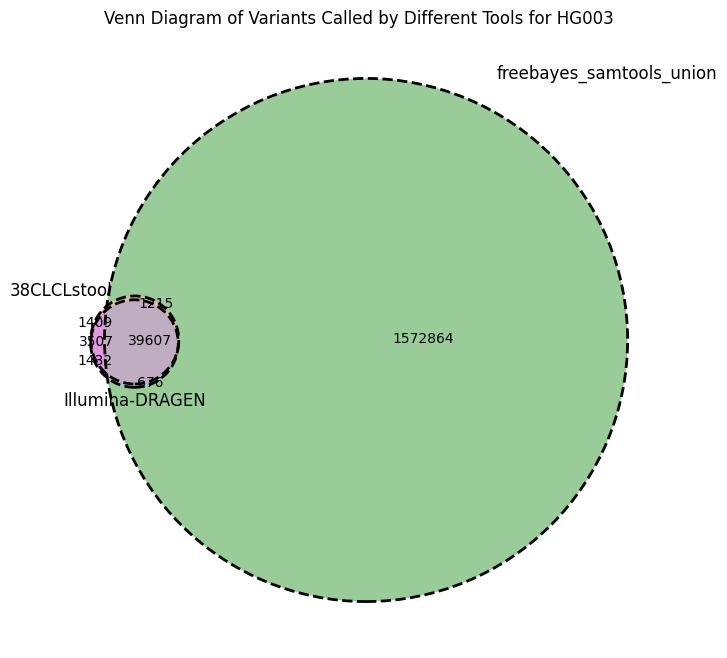

In [ ]:
# Generate Venn diagram
plt.figure(figsize=(10, 8))
venn_labels = {tool: len(variant_sets[tool]) for tool in tools}
venn_sets = (variant_sets[tools[0]], variant_sets[tools[1]], variant_sets[tools[2]])
venn3(venn_sets, set_labels=(tools[0], tools[1], tools[2]))

# Optionally, add Venn diagram circles for a cleaner look
venn3_circles(venn_sets, linestyle='dashed')

plt.title(f'Venn Diagram of Variants Called by Different Tools for {sample}')
plt.show()

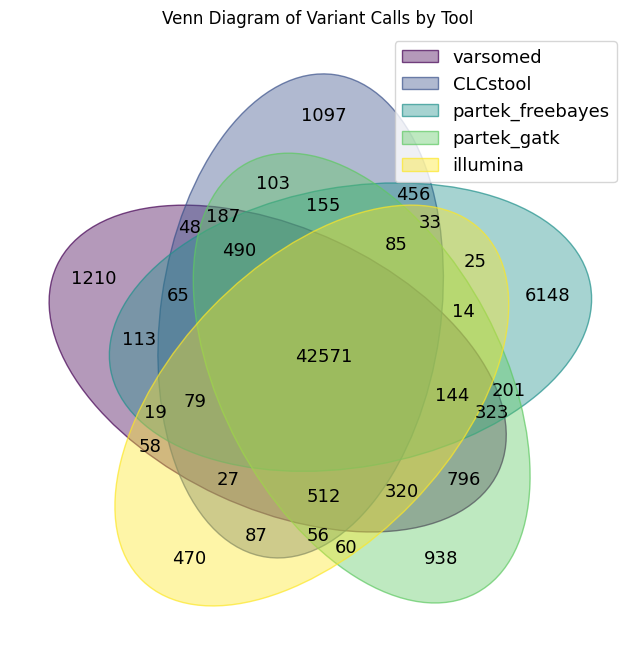

In [ ]:
# Function to parse the processed VCF and extract variant information
def parse_vcf(file_path):
    variants = set()
    with gzip.open(file_path, 'rt') as f:
        for line in f:
            if not line.startswith('#'):
                parts = line.strip().split('\t')
                chrom = parts[0].replace('chr', '')  # Remove 'chr' prefix
                pos = int(parts[1])
                ref = parts[3]
                alt = parts[4]
                variants.add((chrom, pos, ref, alt))
    return variants

# List of VCF files to load
vcf_files = {
    'varsomed': 'HG001_varsomed.vcf.gz',
    'CLCstool': 'HG001_CLCstool.vcf.gz',
    'partek_freebayes': 'HG001_partek_freebayes.vcf.gz',
    'partek_gatk': 'HG001_partek_gatk.vcf.gz',
    'illumina': 'HG001_illumina.vcf.gz'
}

# Parse the VCF files and store the variant sets
variant_sets = {name: parse_vcf(path) for name, path in vcf_files.items()}

# Combine all unique variants into a single set
all_variants = set()
for variants in variant_sets.values():
    all_variants.update(variants)

# Create a boolean DataFrame
variant_dict = {variant: {tool: (variant in variants) for tool, variants in variant_sets.items()} for variant in all_variants}
variant_df = pd.DataFrame.from_dict(variant_dict, orient='index')

# Ensure the DataFrame values are boolean
variant_df = variant_df.astype(bool)

# Extract the sets for each tool
sets = {tool: set(variant_df.index[variant_df[tool]]) for tool in vcf_files.keys()}

# Create the Venn diagram
venn(sets)
plt.title("Venn Diagram of Variant Calls by Tool")
plt.show()

####Upset plot of all TP in each variant caller based on the TRUTH column in the vcf file

/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

<Figure size 1200x800 with 0 Axes>

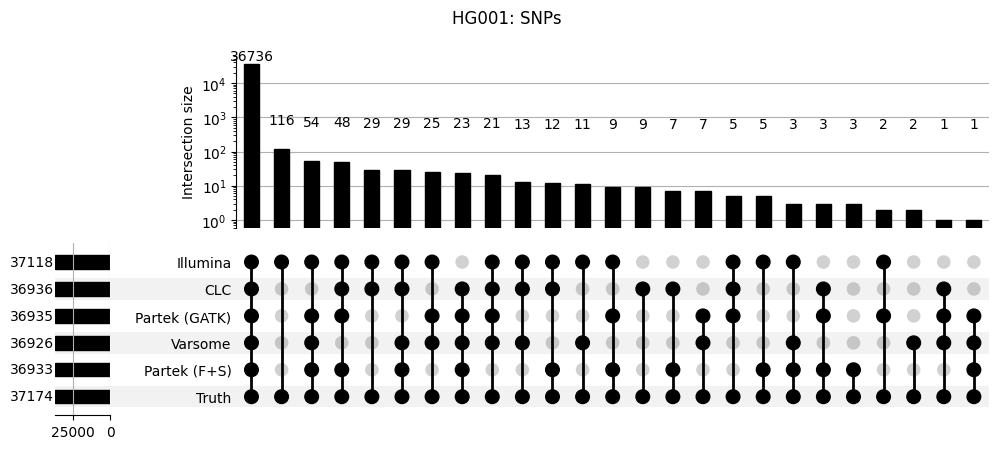

/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

<Figure size 1200x800 with 0 Axes>

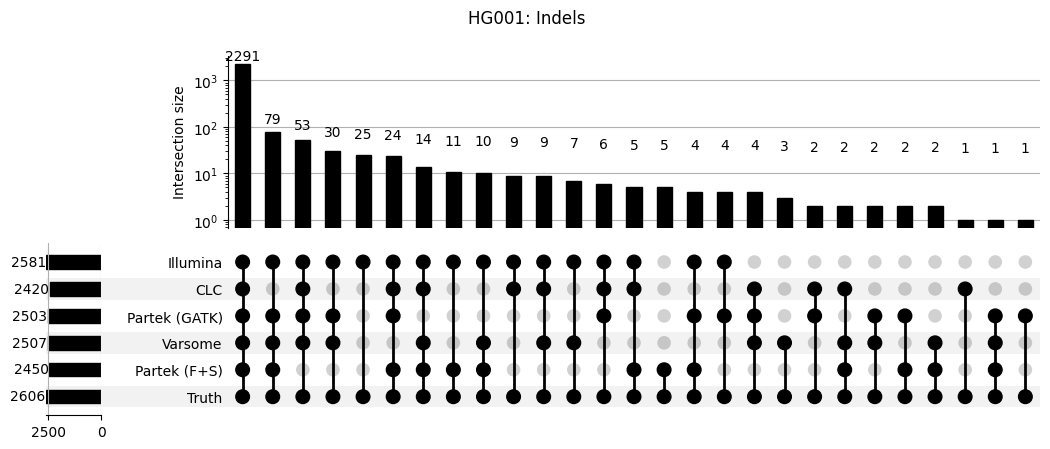

In [ ]:
# Function to parse a VCF file
def parse_vcf(file_path, truth_set=False):
    variants = set()
    variant_details = {}  # To store details including ref and alt
    with gzip.open(file_path, 'rt') as f:
        for line in f:
            if not line.startswith('#'):
                parts = line.strip().split('\t')
                chrom = parts[0].replace('chr', '')
                pos = int(parts[1])
                ref = parts[3]
                alts = tuple(parts[4].split(','))  # Convert list of alt alleles to a tuple

                if truth_set:
                    # Store reference and alternate for the truth set as a tuple
                    variants.add((chrom, pos, ref, alts))  # Including ref and alts for the truth set
                else:
                    truth = parts[9].split(':')
                    tp_fp_fn = truth[1] if len(truth) > 1 else 'UNK'
                    if tp_fp_fn == 'TP':
                        for alt in alts:
                            key = (chrom, pos)
                            if key not in variant_details:
                                variant_details[key] = {'ref': ref, 'alts': alts}
                            variants.add((chrom, pos, ref, alt))
    return variants, variant_details

# List of tool-specific VCF files
vcf_files = {
    'Illumina': ['DRAGEN_HG001.vcf.gz'],
    'CLC': ['CLC_HG001.vcf.gz'],
    'Partek (GATK)': ['PartekGATK_HG001.vcf.gz'],
    'Varsome': ['Varsome_HG001.vcf.gz'],
    'Partek (F+S)': ['PartekFS_HG001.vcf.gz']
}

# Truth set VCF file
truth_vcf_path = 'HG001_GRCh38_1_22_v4.2.1_benchmark.vcf.gz'

# Parse the TRUTH set (extract only chromosome, position, ref, and alt)
truth_set, _ = parse_vcf(truth_vcf_path, truth_set=True)

# Parse tool-specific VCF files and get variant details (ref, alt)
variant_sets_tp = {}
variant_details_tp = {}
for name, paths in vcf_files.items():
    combined_variants = set()
    combined_variant_details = {}
    for path in paths:
        variants, details = parse_vcf(path)
        combined_variants.update(variants)
        combined_variant_details.update(details)
    variant_sets_tp[name] = combined_variants
    variant_details_tp[name] = combined_variant_details

# Create a set of (chrom, pos) pairs from the truth set, including ref and alt
truth_positions = { (chrom, pos): (ref, alts) for chrom, pos, ref, alts in truth_set }

# Combine all tool-specific variants
all_variants_tp = set()
for variants in variant_sets_tp.values():
    all_variants_tp.update(variants)

variant_dict_tp = {}

for tool, variants in variant_sets_tp.items():
    for chrom, pos, ref, alt in variants:
        key = (chrom, pos)
        if key not in variant_dict_tp:
            variant_dict_tp[key] = { t: False for t in variant_sets_tp }  # Initialize all tools as False
        variant_dict_tp[key][tool] = True  # Set True for the current tool

# Add the Truth column based on chrom, pos
for key in variant_dict_tp.keys():
    variant_dict_tp[key]['Truth'] = key in truth_positions

# Convert to DataFrame
variant_df_tp = pd.DataFrame.from_dict(variant_dict_tp, orient='index')

# Ensure boolean values
variant_df_tp = variant_df_tp.astype(bool)

# Add SNP/INDEL classification based on the length of Reference and Alternate alleles
variant_df_tp['Reference'] = variant_df_tp.index.map(
    lambda key: variant_details_tp['Illumina'].get(key, {}).get('ref', '')  # Populate from Illumina ref if available
)
variant_df_tp['Alternate'] = variant_df_tp.index.map(
    lambda key: variant_details_tp['Illumina'].get(key, {}).get('alts', [''])[0] if variant_details_tp['Illumina'].get(key, {}).get('alts') else ''  # Populate from Illumina alt if available
)

# If ref and alt are empty, get them from the truth set
for key in variant_df_tp.index:
    if variant_df_tp.loc[key, 'Reference'] == '' or variant_df_tp.loc[key, 'Alternate'] == '':
        chrom, pos = key
        # Check if it's a match in the truth set
        if (chrom, pos) in truth_positions:
            ref, alts = truth_positions[(chrom, pos)]  # Get the ref and alts from the truth set
            # Use the first alt allele if available, otherwise set to an empty string
            variant_df_tp.loc[key, 'Reference'] = ref
            variant_df_tp.loc[key, 'Alternate'] = alts[0] if alts else ''

# Classify as SNP or INDEL (if ref or alt is empty, classify as SNP)
variant_df_tp['Variant_Type'] = variant_df_tp.apply(
    lambda row: 'SNP' if (len(row['Reference']) == 1 and len(row['Alternate']) == 1) or not row['Reference'] or not row['Alternate'] else 'INDEL', axis=1
)


# Filter to include only variants where TRUTH is True and intersect with at least one other caller
variant_df_tp_filtered = variant_df_tp[(
    variant_df_tp['Truth']) &  # Keep only rows where TRUTH is True
    variant_df_tp[['Partek (F+S)', 'Varsome', 'Partek (GATK)', 'CLC', 'Illumina']].any(axis=1)  # At least one other caller is True
]


# Separate the data into SNPs and INDELs
variant_df_snps = variant_df_tp_filtered[variant_df_tp_filtered['Variant_Type'] == 'SNP']
variant_df_indels = variant_df_tp_filtered[variant_df_tp_filtered['Variant_Type'] == 'INDEL']

# Check if the rows exist before moving them for HG001
rows_to_move = variant_df_indels.loc[
    variant_df_indels.index.isin([('13', 31148483), ('11', 90218199)])
]

#If rows_to_move is not empty, move them to SNP DataFrame
if not rows_to_move.empty:
    # Move rows to SNP DataFrame
    variant_df_snps = pd.concat([variant_df_snps, rows_to_move])

    # Remove the rows from the INDEL DataFrame
    variant_df_indels = variant_df_indels.drop(rows_to_move.index)

    # Update the 'Variant_Type' to 'SNP' in SNP DataFrame
    variant_df_snps.loc[rows_to_move.index, 'Variant_Type'] = 'SNP'
else:
    print("No matching rows to move.")

# Function to create and save an UpSet plot
def create_upset_plot(data, title, output_path):
    data = data.set_index(['Truth', 'Partek (F+S)', 'Varsome', 'Partek (GATK)', 'CLC', 'Illumina'])
    plt.figure(figsize=(12, 8))
    upset = UpSet(
        data,
        subset_size='count',
        show_counts='%d',
        sort_by='cardinality',
        sort_categories_by=None,
        element_size=28,
        totals_plot_elements=2,
    )
    upset.plot()
    plt.yscale('log')  # Set logarithmic scale for y-axis
    plt.suptitle(title)
    plt.savefig(output_path)  # Save the plot as a TIFF image
    plt.show()

# Create and save SNP plot
create_upset_plot(
    variant_df_snps,
    'HG001: SNPs',
    'hg001_upset_snps_filtered_truth.tif'
)

# Create and save INDEL plot
create_upset_plot(
    variant_df_indels,
    'HG001: Indels',
    'hg001_upset_indels_filtered_truth.tif'
)


/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

<Figure size 1200x800 with 0 Axes>

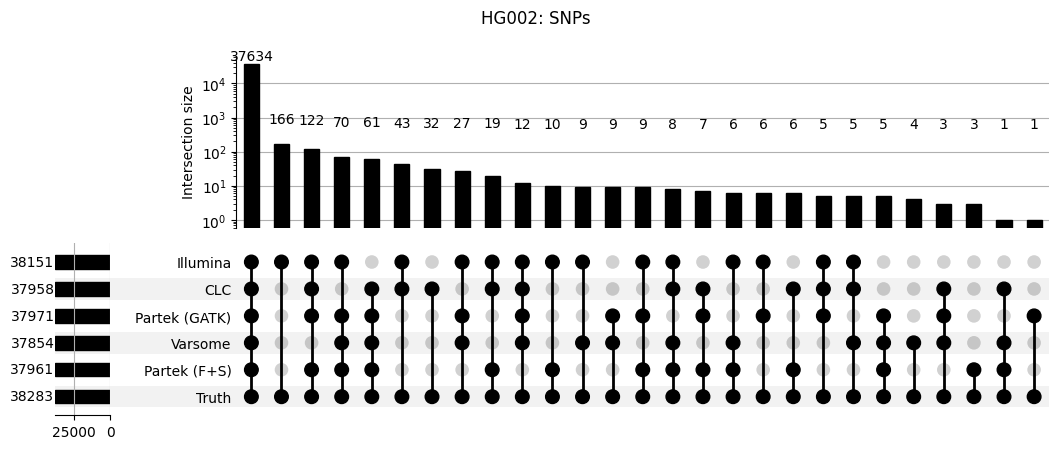

/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

<Figure size 1200x800 with 0 Axes>

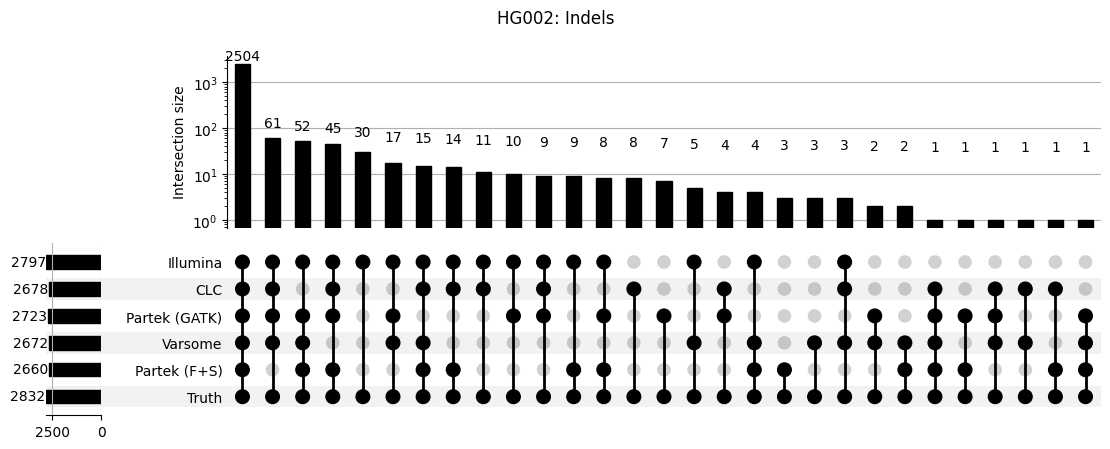

In [ ]:
# Function to parse a VCF file
def parse_vcf(file_path, truth_set=False):
    variants = set()
    variant_details = {}  # To store details including ref and alt
    with gzip.open(file_path, 'rt') as f:
        for line in f:
            if not line.startswith('#'):
                parts = line.strip().split('\t')
                chrom = parts[0].replace('chr', '')
                pos = int(parts[1])
                ref = parts[3]
                alts = tuple(parts[4].split(','))  # Convert list of alt alleles to a tuple

                if truth_set:
                    # Extract chrom, pos, ref, and alt for the truth set
                    variants.add((chrom, pos, ref, alts))
                else:
                    truth = parts[9].split(':')
                    tp_fp_fn = truth[1] if len(truth) > 1 else 'UNK'
                    if tp_fp_fn == 'TP':
                        variants.add((chrom, pos))  # Only chrom and pos for variant caller
    return variants

# List of tool-specific VCF files
vcf_files = {
    'Illumina': ['DRAGEN_HG002.vcf.gz'],
    'CLC': ['CLC_HG002.vcf.gz'],
    'Partek (GATK)': ['PartekGATK_HG002.vcf.gz'],
    'Varsome': ['Varsome_HG002.vcf.gz'],
    'Partek (F+S)': ['PartekFS_HG002.vcf.gz']
}

# Truth set VCF file
truth_vcf_path = 'HG002_GRCh38_1_22_v4.2.1_benchmark.vcf.gz'

# Parse the TRUTH set (extract chrom, pos, ref, and alt)
truth_set = parse_vcf(truth_vcf_path, truth_set=True)

# Parse tool-specific VCF files and get only chrom and pos
variant_sets_tp = {}
for name, paths in vcf_files.items():
    combined_variants = set()
    for path in paths:
        variants = parse_vcf(path)
        combined_variants.update(variants)
    variant_sets_tp[name] = combined_variants

# Create a dictionary mapping (chrom, pos) to ref and alt for the truth set
truth_positions = { (chrom, pos): (ref, alts) for chrom, pos, ref, alts in truth_set }

# Combine all tool-specific variants
all_variants_tp = set()
for variants in variant_sets_tp.values():
    all_variants_tp.update(variants)

variant_dict_tp = {}

for tool, variants in variant_sets_tp.items():
    for chrom, pos in variants:
        key = (chrom, pos)
        if key not in variant_dict_tp:
            variant_dict_tp[key] = { t: False for t in variant_sets_tp }  # Initialize all tools as False
        variant_dict_tp[key][tool] = True  # Set True for the current tool

# Add the Truth column based on chrom, pos
for key in variant_dict_tp.keys():
    variant_dict_tp[key]['Truth'] = key in truth_positions

# Convert to DataFrame
variant_df_tp = pd.DataFrame.from_dict(variant_dict_tp, orient='index')

# Ensure boolean values
variant_df_tp = variant_df_tp.astype(bool)

# Add SNP/INDEL classification based on the length of Reference and Alternate alleles
variant_df_tp['Reference'] = variant_df_tp.index.map(
    lambda key: truth_positions.get(key, ('', ''))[0]  # Get ref from truth set if available
)
variant_df_tp['Alternate'] = variant_df_tp.index.map(
    lambda key: truth_positions.get(key, ('', ('',)))[1][0] if truth_positions.get(key) else ''  # Get first alt if available
)

# Classify as SNP or INDEL
variant_df_tp['Variant_Type'] = variant_df_tp.apply(
    lambda row: 'SNP' if (len(row['Reference']) == 1 and len(row['Alternate']) == 1) else 'INDEL', axis=1
)

# Filter to include only variants where TRUTH is True and intersect with at least one other caller
variant_df_tp_filtered = variant_df_tp[(
    variant_df_tp['Truth']) &  # Keep only rows where TRUTH is True
    variant_df_tp[['Partek (F+S)', 'Varsome', 'Partek (GATK)', 'CLC', 'Illumina']].any(axis=1)  # At least one other caller is True
]

# Separate the data into SNPs and INDELs
variant_df_snps = variant_df_tp_filtered[variant_df_tp_filtered['Variant_Type'] == 'SNP']
variant_df_indels = variant_df_tp_filtered[variant_df_tp_filtered['Variant_Type'] == 'INDEL']

# Check if the rows exist before moving them for HG002
rows_to_move = variant_df_snps.loc[
    variant_df_snps.index.isin([('10', 26702116)])
]

#If rows_to_move is not empty, move them to SNP DataFrame
if not rows_to_move.empty:
    # Move rows to SNP DataFrame
    variant_df_indels = pd.concat([variant_df_indels, rows_to_move])

    # Remove the rows from the INDEL DataFrame
    variant_df_snps = variant_df_snps.drop(rows_to_move.index)

    # Update the 'Variant_Type' to 'SNP' in SNP DataFrame
    variant_df_indels.loc[rows_to_move.index, 'Variant_Type'] = 'INDEL'
else:
    print("No matching rows to move.")


# Function to create and save an UpSet plot
def create_upset_plot(data, title, output_path):
    data = data.set_index(['Truth', 'Partek (F+S)', 'Varsome', 'Partek (GATK)', 'CLC', 'Illumina'])
    plt.figure(figsize=(12, 8))
    upset = UpSet(
        data,
        subset_size='count',
        show_counts='%d',
        sort_by='cardinality',
        sort_categories_by=None,
        element_size=28,
        totals_plot_elements=2,
    )
    upset.plot()
    plt.yscale('log')  # Set logarithmic scale for y-axis
    plt.suptitle(title)
    plt.savefig(output_path)  # Save the plot as a TIFF image
    plt.show()

# Create and save SNP plot
create_upset_plot(
    variant_df_snps,
    'HG002: SNPs',
    'hg002_upset_snps_filtered_truth.tif'
)

# Create and save INDEL plot
create_upset_plot(
    variant_df_indels,
    'HG002: Indels',
    'hg002_upset_indels_filtered_truth.tif'
)


/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

<Figure size 1200x800 with 0 Axes>

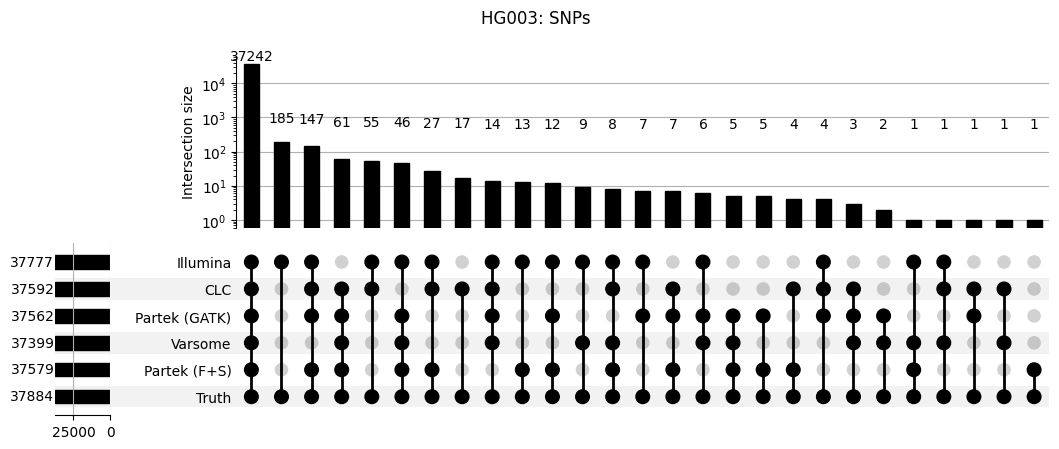

/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

<Figure size 1200x800 with 0 Axes>

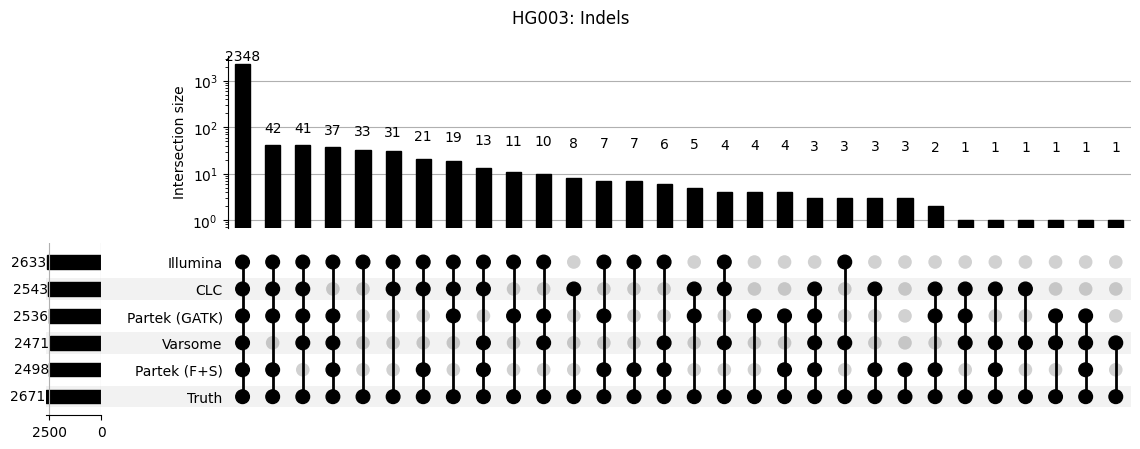

In [ ]:
# Function to parse a VCF file
def parse_vcf(file_path, truth_set=False):
    variants = set()
    variant_details = {}  # To store details including ref and alt
    with gzip.open(file_path, 'rt') as f:
        for line in f:
            if not line.startswith('#'):
                parts = line.strip().split('\t')
                chrom = parts[0].replace('chr', '')
                pos = int(parts[1])
                ref = parts[3]
                alts = tuple(parts[4].split(','))  # Convert list of alt alleles to a tuple

                if truth_set:
                    # Extract chrom, pos, ref, and alt for the truth set
                    variants.add((chrom, pos, ref, alts))
                else:
                    truth = parts[9].split(':')
                    tp_fp_fn = truth[1] if len(truth) > 1 else 'UNK'
                    if tp_fp_fn == 'TP':
                        variants.add((chrom, pos))  # Only chrom and pos for variant caller
    return variants

# List of tool-specific VCF files
vcf_files = {
    'Illumina': ['DRAGEN_HG003.vcf.gz'],
    'CLC': ['CLC_HG003.vcf.gz'],
    'Partek (GATK)': ['PartekGATK_HG003.vcf.gz'],
    'Varsome': ['Varsome_HG003.vcf.gz'],
    'Partek (F+S)': ['PartekFS_HG003.vcf.gz']
}

# Truth set VCF file
truth_vcf_path = 'HG003_GRCh38_1_22_v4.2.1_benchmark.vcf.gz'

# Parse the TRUTH set (extract chrom, pos, ref, and alt)
truth_set = parse_vcf(truth_vcf_path, truth_set=True)

# Parse tool-specific VCF files and get only chrom and pos
variant_sets_tp = {}
for name, paths in vcf_files.items():
    combined_variants = set()
    for path in paths:
        variants = parse_vcf(path)
        combined_variants.update(variants)
    variant_sets_tp[name] = combined_variants

# Create a dictionary mapping (chrom, pos) to ref and alt for the truth set
truth_positions = { (chrom, pos): (ref, alts) for chrom, pos, ref, alts in truth_set }

# Combine all tool-specific variants
all_variants_tp = set()
for variants in variant_sets_tp.values():
    all_variants_tp.update(variants)

variant_dict_tp = {}

for tool, variants in variant_sets_tp.items():
    for chrom, pos in variants:
        key = (chrom, pos)
        if key not in variant_dict_tp:
            variant_dict_tp[key] = { t: False for t in variant_sets_tp }  # Initialize all tools as False
        variant_dict_tp[key][tool] = True  # Set True for the current tool

# Add the Truth column based on chrom, pos
for key in variant_dict_tp.keys():
    variant_dict_tp[key]['Truth'] = key in truth_positions

# Convert to DataFrame
variant_df_tp = pd.DataFrame.from_dict(variant_dict_tp, orient='index')

# Ensure boolean values
variant_df_tp = variant_df_tp.astype(bool)

# Add SNP/INDEL classification based on the length of Reference and Alternate alleles
variant_df_tp['Reference'] = variant_df_tp.index.map(
    lambda key: truth_positions.get(key, ('', ''))[0]  # Get ref from truth set if available
)
variant_df_tp['Alternate'] = variant_df_tp.index.map(
    lambda key: truth_positions.get(key, ('', ('',)))[1][0] if truth_positions.get(key) else ''  # Get first alt if available
)

# Classify as SNP or INDEL
variant_df_tp['Variant_Type'] = variant_df_tp.apply(
    lambda row: 'SNP' if (len(row['Reference']) == 1 and len(row['Alternate']) == 1) else 'INDEL', axis=1
)

# Filter to include only variants where TRUTH is True and intersect with at least one other caller
variant_df_tp_filtered = variant_df_tp[(
    variant_df_tp['Truth']) &  # Keep only rows where TRUTH is True
    variant_df_tp[['Partek (F+S)', 'Varsome', 'Partek (GATK)', 'CLC', 'Illumina']].any(axis=1)  # At least one other caller is True
]

# Separate the data into SNPs and INDELs
variant_df_snps = variant_df_tp_filtered[variant_df_tp_filtered['Variant_Type'] == 'SNP']
variant_df_indels = variant_df_tp_filtered[variant_df_tp_filtered['Variant_Type'] == 'INDEL']

# Row to move from SNPs to INDELs
snps_to_indels = variant_df_snps.loc[
    variant_df_snps.index.isin([('17', 27638241)])  # Change this to the row you want to move
]

# Row to move from INDELs to SNPs
indels_to_snps = variant_df_indels.loc[
    variant_df_indels.index.isin([('2', 33361397)])  # Change this to the row you want to move
]

# If SNP row exists, move it to INDELs
if not snps_to_indels.empty:
    variant_df_indels = pd.concat([variant_df_indels, snps_to_indels])
    variant_df_snps = variant_df_snps.drop(snps_to_indels.index)
    variant_df_indels.loc[snps_to_indels.index, 'Variant_Type'] = 'INDEL'

# If INDEL row exists, move it to SNPs
if not indels_to_snps.empty:
    variant_df_snps = pd.concat([variant_df_snps, indels_to_snps])
    variant_df_indels = variant_df_indels.drop(indels_to_snps.index)
    variant_df_snps.loc[indels_to_snps.index, 'Variant_Type'] = 'SNP'


# Function to create and save an UpSet plot
def create_upset_plot(data, title, output_path):
    data = data.set_index(['Truth', 'Partek (F+S)', 'Varsome', 'Partek (GATK)', 'CLC', 'Illumina'])
    plt.figure(figsize=(12, 8))
    upset = UpSet(
        data,
        subset_size='count',
        show_counts='%d',
        sort_by='cardinality',
        sort_categories_by=None,
        element_size=28,
        totals_plot_elements=2,
    )
    upset.plot()
    plt.yscale('log')  # Set logarithmic scale for y-axis
    plt.suptitle(title)
    plt.savefig(output_path)  # Save the plot as a TIFF image
    plt.show()

# Create and save SNP plot
create_upset_plot(
    variant_df_snps,
    'HG003: SNPs',
    'hg003_upset_snps_filtered_truth.tif'
)

# Create and save INDEL plot
create_upset_plot(
    variant_df_indels,
    'HG003: Indels',
    'hg003_upset_indels_filtered_truth.tif'
)

In [ ]:
variant_df_indels.head(1000)

Illumina   CLC  Partek (GATK)  Varsome  Partek (F+S)  Truth  \
16 24546298       True  True           True     True          True   True   
4  72567405       True  True           True     True          True   True   
3  66346474       True  True           True     True          True   True   
12 48940113       True  True           True     True          True   True   
   108562750      True  True           True     True          True   True   
...                ...   ...            ...      ...           ...    ...   
18 62275513       True  True           True     True          True   True   
   63659394       True  True           True     True          True   True   
17 10639964       True  True           True     True          True   True   
12 21559794       True  True           True     True          True   True   
21 37159784       True  True           True     True          True   True   

                     Reference   Alternate Variant_Type  
16 24546298                  C          CT        INDEL  
4  72567405                 GA           G        INDEL  
3  66346474                  G  GAAGAGTAGA        INDEL  
12 48940113                  G          GA        INDEL  
   108562750                 A          AG        INDEL  
...                        ...         ...          ...  
18 62275513                  A          AT        INDEL  
   63659394                  A          AT        INDEL  
17 10639964                TAA           T        INDEL  
12 21559794   GACATTCTTTGAAATT           G        INDEL  
21 37159784                 TG           T        INDEL  

[1000 rows x 9 columns]

###Codes beyond this point are trial and error codes and figures generated are not published


<ipython-input-52-fce988955f24>:71: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = heatmap_data.replace({'TP': 1, 'FP': -1, 'FN': 0})
<ipython-input-52-fce988955f24>:82: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  variant_type_bar = heatmap_data[['Variant_Type']].replace({'snps': 1, 'indels': 2}).astype(int)
<ipython-input-52-fce988955f24>:82: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that prese

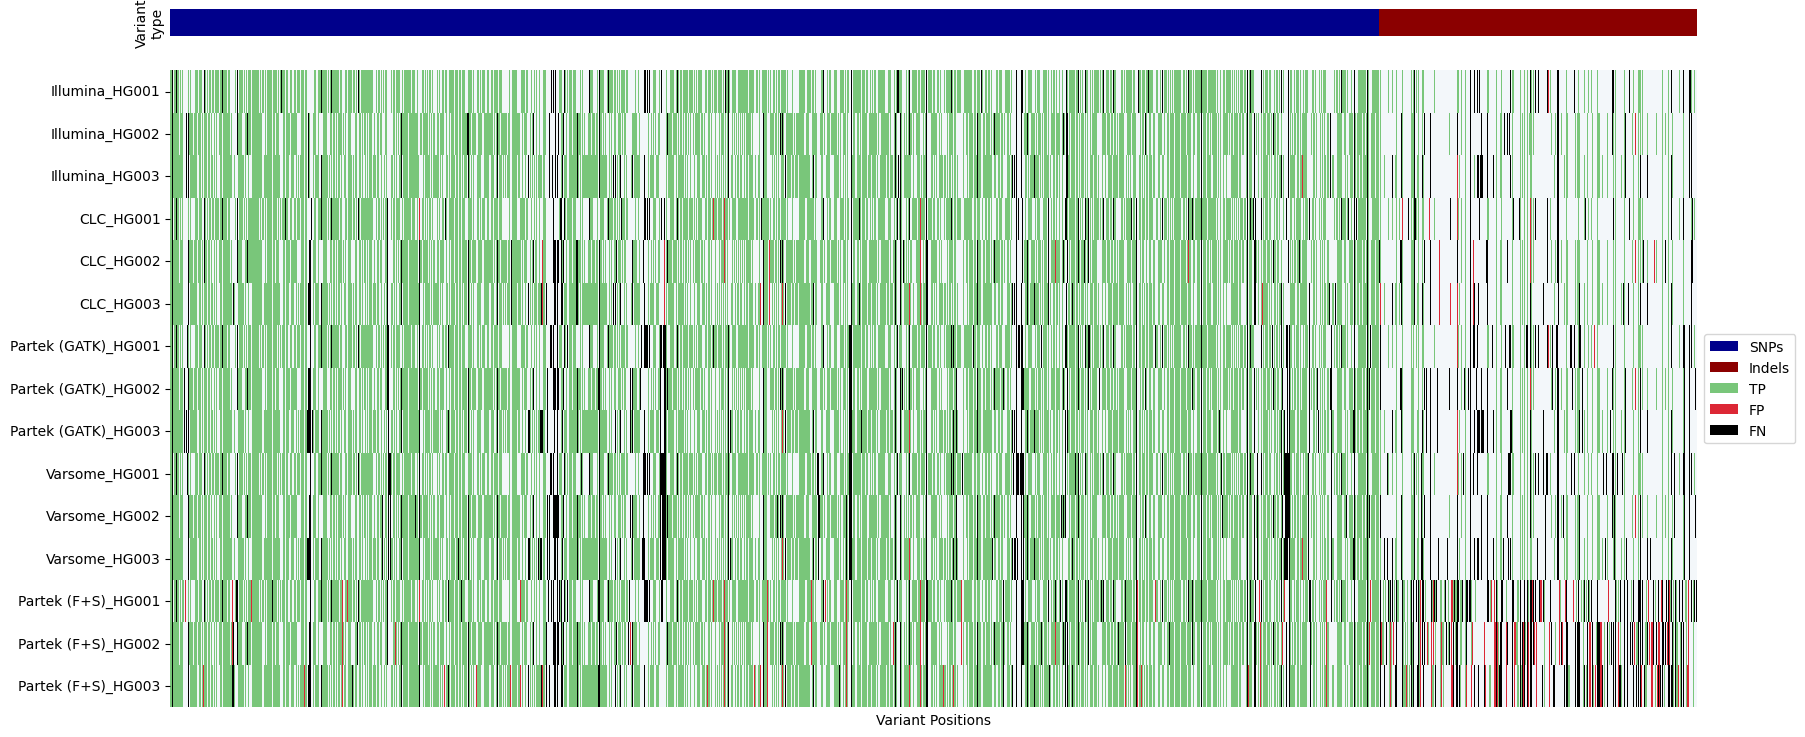

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
from matplotlib import gridspec
from scipy.cluster.hierarchy import linkage, dendrogram, optimal_leaf_ordering
from scipy.spatial.distance import jaccard
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
import numpy as np

# Function to parse the processed VCF and extract variant information
def parse_vcf(file_path):
    variants = []
    with gzip.open(file_path, 'rt') as f:
        for line in f:
            if not line.startswith('#'):
                parts = line.strip().split('\t')
                chrom = parts[0].replace('chr', '')  # Remove 'chr' prefix
                pos = int(parts[1])
                ref = parts[3]
                alt = parts[4]
                info = parts[7]
                query = parts[10].split(':')
                tp_fp_fn = query[1] if len(query) > 1 else 'UNK'
                var_type = 'indels' if len(ref) != len(alt) else 'snps'
                variants.append((chrom, pos, ref, alt, var_type, tp_fp_fn))
    return pd.DataFrame(variants, columns=['Chromosome', 'Position', 'Ref', 'Alt', 'Variant_Type', 'Status'])

# List of VCF files to load
vcf_files = [
    'PartekGATK_HG001.vcf.gz',
    'Varsome_HG001.vcf.gz',
    'DRAGEN_HG001.vcf.gz',
    'CLC_HG001.vcf.gz',
    'PartekFS_HG001.vcf.gz',
    'PartekGATK_HG002.vcf.gz',
    'Varsome_HG002.vcf.gz',
    'DRAGEN_HG002.vcf.gz',
    'CLC_HG002.vcf.gz',
    'PartekFS_HG002.vcf.gz',
    'PartekGATK_HG003.vcf.gz',
    'Varsome_HG003.vcf.gz',
    'DRAGEN_HG003.vcf.gz',
    'CLC_HG003.vcf.gz',
    'PartekFS_HG003.vcf.gz'
]

# Parse the VCF files
variant_data = []
for file in vcf_files:
    sample_data = parse_vcf(file)
    sample_name = file.split('/')[-1].split('_')[0]  # Extract sample name from file name
    sample_data['Sample'] = sample_name
    sample_data['HG'] = file.split('_')[1].split('.')[0]  # Extract HG001, HG002, or HG003 from file name
    variant_data.append(sample_data)

# Combine all variant data
combined_data = pd.concat(variant_data)

# Pivot the data to create the heatmap matrix
heatmap_data = combined_data.pivot_table(index=['Chromosome', 'Position', 'Ref', 'Alt', 'Variant_Type'],
                                         columns=['Sample', 'HG'],
                                         values='Status',
                                         aggfunc=lambda x: 'TP' if 'TP' in x.values else ('FP' if 'FP' in x.values else 'FN'))


# Calculate summary metrics (TP, FP, FN) for each variant caller
summary_metrics = heatmap_data.apply(lambda x: pd.Series({'TP': (x == 'TP').sum(), 'FP': (x == 'FP').sum(), 'FN': (x == 'FN').sum()}), axis=0)

# Replace TP, FP, and FN with numeric values for heatmap
heatmap_data = heatmap_data.replace({'TP': 1, 'FP': -1, 'FN': 0})

# Order by Variant_Type (SNPs first, then indels) and Chromosome (1-22, X, Y)
chrom_order = list(map(str, range(1, 23))) + ['X', 'Y']
heatmap_data = heatmap_data.reset_index()
heatmap_data['Chromosome'] = pd.Categorical(heatmap_data['Chromosome'], categories=chrom_order, ordered=True)
heatmap_data['Position'] = heatmap_data['Position'].astype(int)
heatmap_data['Variant_Type'] = pd.Categorical(heatmap_data['Variant_Type'], categories=['snps', 'indels'], ordered=True)
heatmap_data.sort_values(by=['Variant_Type', 'Chromosome', 'Position'], inplace=True)

# Extract the variant type bar
variant_type_bar = heatmap_data[['Variant_Type']].replace({'snps': 1, 'indels': 2}).astype(int)

# Drop the multi-index columns after sorting
heatmap_data.set_index(['Chromosome', 'Position', 'Ref', 'Alt', 'Variant_Type'], inplace=True)

# Replace NaNs with a placeholder value (-2) for the heatmap
heatmap_data = heatmap_data.fillna(-2)

# Create a mapping from sample names to more readable labels
sample_mapping = {
    'PartekGATK': 'Partek (GATK)',
    'Varsome': 'Varsome',
    'DRAGEN': 'Illumina',
    'CLC': 'CLC',
    'PartekFS': 'Partek (F+S)'
}

# Rename the columns according to the sample mapping and HG number
heatmap_data.columns = [f"{sample_mapping[col[0]]}_HG{col[1][-1].zfill(3)}" for col in heatmap_data.columns]

# Ensure the data has the desired column order: Illumina HG001, HG002, HG003, CLC HG001, HG002, HG003, etc.
ordered_columns = []
for hg in ['001', '002', '003']:
    for sample in ['Illumina', 'CLC', 'Partek (GATK)', 'Varsome', 'Partek (F+S)']:
        ordered_columns.append(f"{sample}_HG{hg}")
heatmap_data = heatmap_data[ordered_columns]

# Function to cluster within each variant caller
def cluster_variant_caller(data, samples):
    sub_data = data[samples]
    print(f"Attempting to cluster samples: {samples}")
    print(f"Sub-data shape before transpose: {sub_data.shape}")
    if sub_data.empty:
        print(f"Warning: No data available for samples: {samples}")
        return []
    if sub_data.shape[1] == 1:
        return [0]

    # Calculate a similarity matrix based ONLY on TP calls at the same position
    similarity_matrix = np.zeros((len(samples), len(samples)))
    for i in range(len(samples)):
        for j in range(i + 1, len(samples)):
            # Count matching TP calls
            num_matching_tp = ((sub_data[samples[i]] == 1) & (sub_data[samples[j]] == 1)).sum()

            # Calculate similarity based ONLY on TP matches
            total_tp = (sub_data[samples[i]] == 1).sum() + (sub_data[samples[j]] == 1).sum()
            if total_tp > 0:  # Avoid division by zero
                similarity_matrix[i, j] = similarity_matrix[j, i] = num_matching_tp / total_tp
            else:
              similarity_matrix[i, j] = similarity_matrix[j, i] = 0  # If no TPs, similarity is 0

    # Use the similarity matrix for clustering (convert to distance matrix first)
    distance_matrix = 1 - similarity_matrix
    linkage_matrix = linkage(distance_matrix, method='median')
    ordered_leaves = optimal_leaf_ordering(linkage_matrix, distance_matrix)
    dendro = dendrogram(ordered_leaves, no_plot=True)
    return dendro['leaves']

# Reorder columns by variant caller, then by HG number, with internal clustering
clustered_columns = []

for sample in ['Illumina', 'CLC', 'Partek (GATK)', 'Varsome', 'Partek (F+S)']:
    for hg in ['001', '002', '003']:
        sample_column = f"{sample}_HG{hg}"
        if sample_column in heatmap_data.columns:
            clustered_columns.append(sample_column)

# Reorder the heatmap data based on clustered columns
heatmap_data = heatmap_data[clustered_columns]

# Perform clustering across all variant callers after internal clustering
combined_metrics = summary_metrics.T.fillna(0)
combined_linkage = linkage(combined_metrics, method='median', metric='euclidean')
combined_linkage = optimal_leaf_ordering(combined_linkage, combined_metrics)


# Plotting
fig = plt.figure(figsize=(20, 14))
gs = gridspec.GridSpec(3, 2, width_ratios=[2, 18], height_ratios=[0.5, 12, 12])

# Variant type bar
ax0 = plt.subplot(gs[0, 1])
sns.heatmap(variant_type_bar.T, cmap=sns.color_palette(["#00008B", "#8B0000"]), cbar=False, ax=ax0)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('')
ax0.set_ylabel('Variant\ntype')


# Custom colormap to ensure NaNs are white, TP are light green, FP are light red, FN are black
cmap = LinearSegmentedColormap.from_list('custom_cmap', ["#F3F7FA", "#DC2735", "black", "#79C67A"])
bounds = [-2.5, -1.5, -0.5, 0.5, 1.5]
norm = BoundaryNorm(bounds, cmap.N)

# Main heatmap
ax2 = plt.subplot(gs[1, 1:])
sns.heatmap(heatmap_data.T, cmap=cmap, cbar=False, ax=ax2, norm=norm)
ax2.set_xlabel('Variant Positions')
ax2.set_xticks([])  # Remove x-tick labels for clarity

# Add legend
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor='#00008B', label='SNPs'),
                   Patch(facecolor='#8B0000', label='Indels'),
                   Patch(facecolor='#79C67A', label='TP'),
                   Patch(facecolor='#DC2735', label='FP'),
                   Patch(facecolor='black', label='FN')]

ax2.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title='')

plt.tight_layout()
plt.show()

In [ ]:
# Count the number of True Negatives (TN) for each sample of each variant caller
tn_counts = (heatmap_data == -2).sum(axis=0)

# Organize the TN counts by variant caller and sample
tn_counts_by_sample = tn_counts.groupby(level=0).sum()

# Display the result
print(tn_counts_by_sample)

CLC_HG001              42358
CLC_HG002              42027
CLC_HG003              42186
Illumina_HG001         43850
Illumina_HG002         43392
Illumina_HG003         43494
Partek (F+S)_HG001     37591
Partek (F+S)_HG002     36471
Partek (F+S)_HG003     36608
Partek (GATK)_HG001    41454
Partek (GATK)_HG002    41301
Partek (GATK)_HG003    41137
Varsome_HG001          41447
Varsome_HG002          41266
Varsome_HG003          41247
dtype: int64


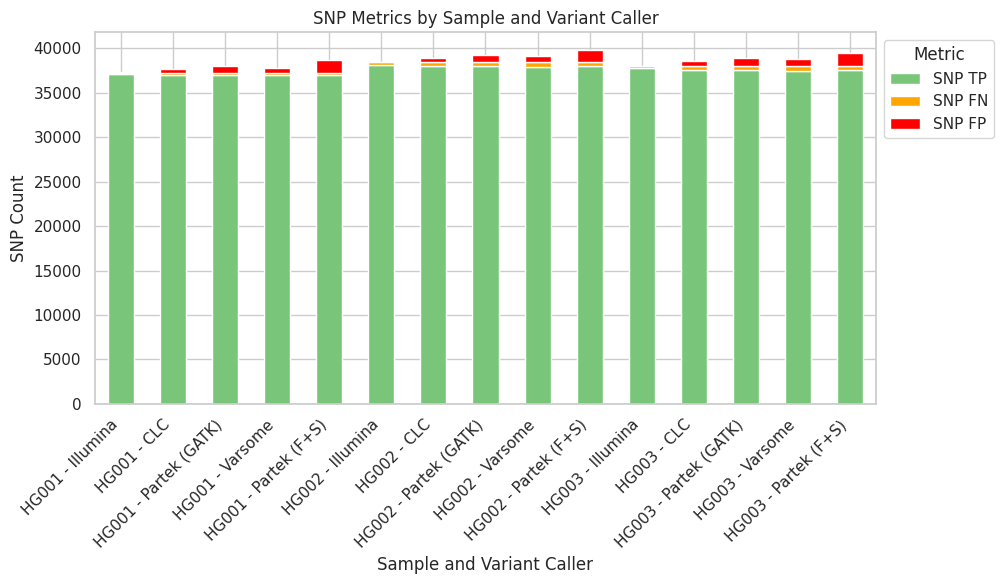

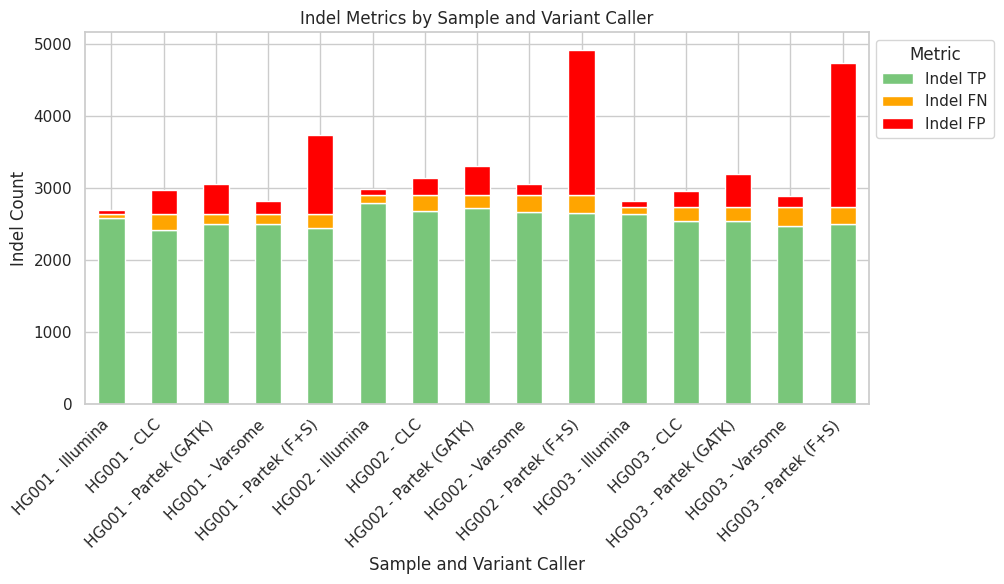

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Creating the DataFrame
data = {
    "Sample": ["HG001"] * 5 + ["HG002"] * 5 + ["HG003"] * 5,
    "Variant Caller": ["Illumina", "CLC", "Partek (GATK)", "Varsome", "Partek (F+S)"] * 3,
    "SNP TP": [37118, 36936, 36935, 36926, 36933,
               38151, 37958, 37971, 37854, 37961,
               37777, 37592, 37562, 37399, 37579],
    "SNP FP": [48, 468, 809, 533, 1443,
               48, 515, 805, 732, 1378,
               30, 553, 843, 770, 1424],
    "SNP FN": [104, 286, 287, 296, 289,
               256, 449, 436, 553, 446,
               224, 409, 439, 602, 422],
    "Indel TP": [2581, 2420, 2503, 2507, 2450,
                 2797, 2678, 2723, 2672, 2660,
                 2633, 2543, 2536, 2471, 2498],
    "Indel FP": [55, 324, 416, 183, 1095,
                 79, 236, 404, 154, 2009,
                 95, 227, 462, 157, 2006],
    "Indel FN": [62, 223, 140, 136, 193,
                 112, 231, 186, 237, 249,
                 98, 188, 195, 260, 233]
}

df = pd.DataFrame(data)

# Create a new column to combine Sample and Variant Caller for x-axis labels
df["Sample - Caller"] = df["Sample"] + " - " + df["Variant Caller"]

# Define color mapping
colors = {"TP": '#79C67A', "FP": 'red', "FN": 'orange'}

### FIGURE 1: SNP Metrics ###
fig1, ax1 = plt.subplots(figsize=(12, 6))

df.plot(kind='bar', x='Sample - Caller', y=['SNP TP', 'SNP FN', 'SNP FP'], stacked=True,
        color=[colors['TP'], colors['FN'], colors['FP']], ax=ax1)

ax1.set_ylabel("SNP Count")
ax1.set_xlabel("Sample and Variant Caller")
ax1.set_title("SNP Metrics by Sample and Variant Caller")

# Move legend outside
ax1.legend(title="Metric", loc='upper left', bbox_to_anchor=(1, 1))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent legend cutoff
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Show SNP figure
plt.show()

### FIGURE 2: Indel Metrics ###
fig2, ax2 = plt.subplots(figsize=(12, 6))

df.plot(kind='bar', x='Sample - Caller', y=['Indel TP', 'Indel FN', 'Indel FP'], stacked=True,
        color=[colors['TP'], colors['FN'], colors['FP']], ax=ax2)

ax2.set_ylabel("Indel Count")
ax2.set_xlabel("Sample and Variant Caller")
ax2.set_title("Indel Metrics by Sample and Variant Caller")

# Move legend outside
ax2.legend(title="Metric", loc='upper left', bbox_to_anchor=(1, 1))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent legend cutoff
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Show Indel figure
plt.show()




<ipython-input-36-7bad838058a6>:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df["Sample - Caller"], rotation=90, ha='center', fontsize=12)  # Explicitly set rotation and alignment


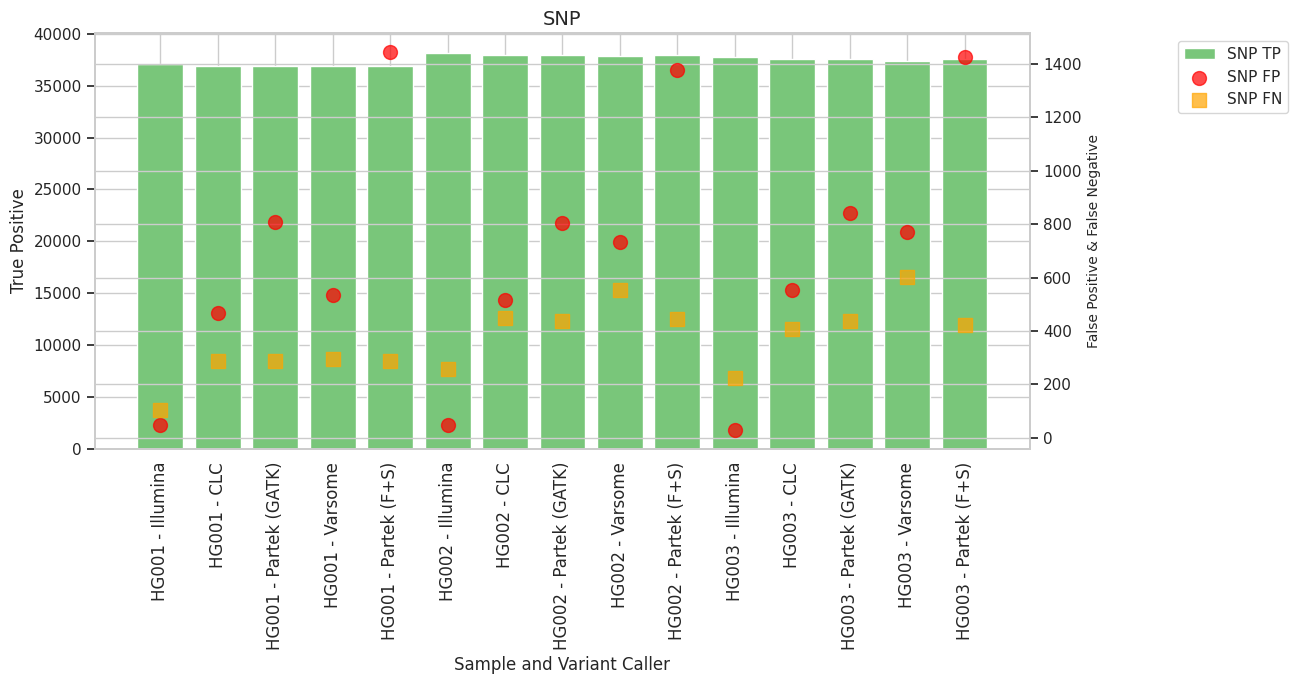

<ipython-input-36-7bad838058a6>:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(df["Sample - Caller"], rotation=90, ha='center', fontsize=12)  # Explicitly set rotation and alignment


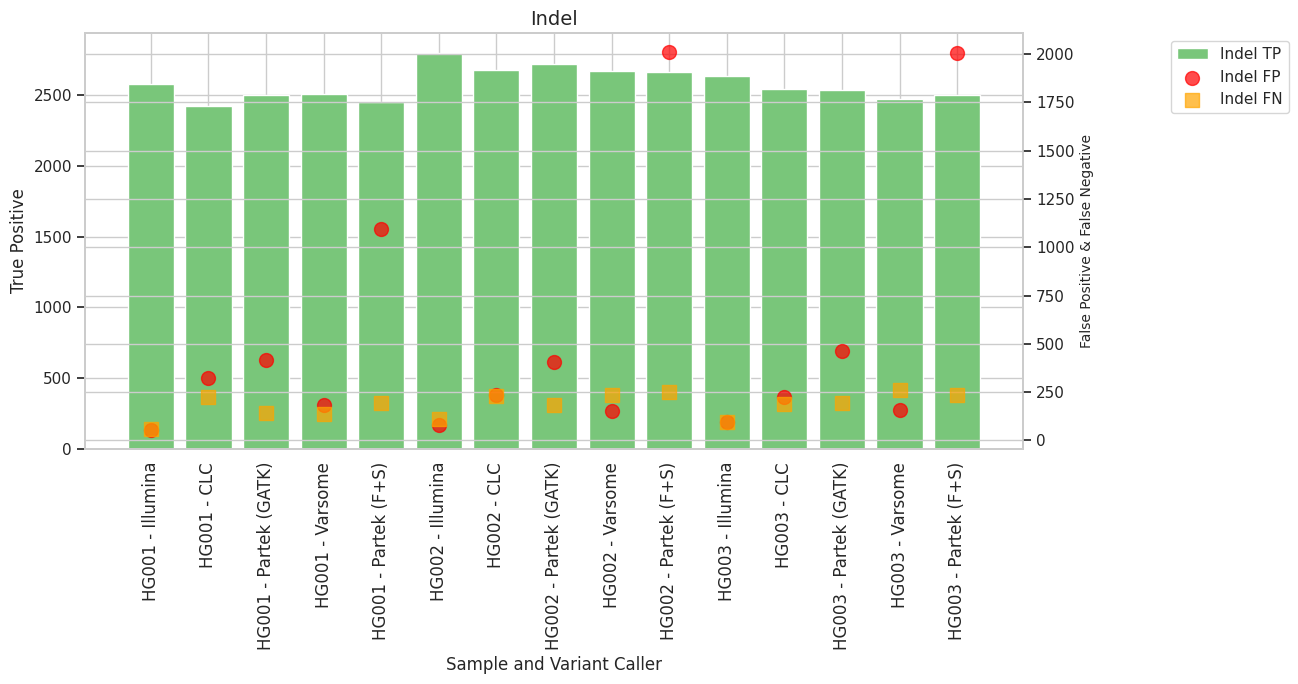

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Creating the DataFrame
data = {
    "Sample": ["HG001"] * 5 + ["HG002"] * 5 + ["HG003"] * 5,
    "Variant Caller": ["Illumina", "CLC", "Partek (GATK)", "Varsome", "Partek (F+S)"] * 3,
    "SNP TP": [37118, 36936, 36935, 36926, 36933,
               38151, 37958, 37971, 37854, 37961,
               37777, 37592, 37562, 37399, 37579],
    "SNP FP": [48, 468, 809, 533, 1443,
               48, 515, 805, 732, 1378,
               30, 553, 843, 770, 1424],
    "SNP FN": [104, 286, 287, 296, 289,
               256, 449, 436, 553, 446,
               224, 409, 439, 602, 422],
    "Indel TP": [2581, 2420, 2503, 2507, 2450,
                 2797, 2678, 2723, 2672, 2660,
                 2633, 2543, 2536, 2471, 2498],
    "Indel FP": [55, 324, 416, 183, 1095,
                 79, 236, 404, 154, 2009,
                 95, 227, 462, 157, 2006],
    "Indel FN": [62, 223, 140, 136, 193,
                 112, 231, 186, 237, 249,
                 98, 188, 195, 260, 233]
}

df = pd.DataFrame(data)

# Create a new column to combine Sample and Variant Caller for x-axis labels
df["Sample - Caller"] = df["Sample"] + " - " + df["Variant Caller"]

# Define color mapping
colors = {"TP": '#79C67A', "FP": 'red', "FN": 'orange'}

### FIGURE 1: SNP Metrics ###
fig1, ax1 = plt.subplots(figsize=(16, 7))  # Increased figure width

# Plot SNP TP as bars (left y-axis)
ax1.bar(df["Sample - Caller"], df["SNP TP"], color=colors['TP'], label="SNP TP")
ax1.set_ylabel("True Positive", fontsize=12)
ax1.set_xlabel("Sample and Variant Caller", fontsize=12)
ax1.set_title("SNP", fontsize=14)

# Create a second y-axis for FP and FN (absolute values)
ax2 = ax1.twinx()
ax2.scatter(df["Sample - Caller"], df["SNP FP"], color=colors['FP'], label="SNP FP", s=100, marker='o', alpha=0.7)  # Translucent
ax2.scatter(df["Sample - Caller"], df["SNP FN"], color=colors['FN'], label="SNP FN", s=100, marker='s', alpha=0.7)  # Square for FN, translucent
ax2.set_ylabel("False Positive & False Negative", fontsize=10)

# Combine legends for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, title="", loc='upper left', bbox_to_anchor=(1.15, 1))  # Shift legend further right

# Rotate x-axis labels and adjust spacing
ax1.set_xticklabels(df["Sample - Caller"], rotation=90, ha='center', fontsize=12)  # Explicitly set rotation and alignment
plt.subplots_adjust(bottom=0.4)  # Add more padding to prevent label cutoff

# Adjust layout to prevent legend cutoff
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Show SNP figure
plt.show()

### FIGURE 2: Indel Metrics ###
fig2, ax3 = plt.subplots(figsize=(16, 7))  # Increased figure width

# Plot Indel TP as bars (left y-axis)
ax3.bar(df["Sample - Caller"], df["Indel TP"], color=colors['TP'], label="Indel TP")
ax3.set_ylabel("True Positive", fontsize=12)
ax3.set_xlabel("Sample and Variant Caller", fontsize=12)
ax3.set_title("Indel", fontsize=14)

# Create a second y-axis for FP and FN (absolute values)
ax4 = ax3.twinx()
ax4.scatter(df["Sample - Caller"], df["Indel FP"], color=colors['FP'], label="Indel FP", s=100, marker='o', alpha=0.7)  # Translucent
ax4.scatter(df["Sample - Caller"], df["Indel FN"], color=colors['FN'], label="Indel FN", s=100, marker='s', alpha=0.7)  # Square for FN, translucent
ax4.set_ylabel("False Positive & False Negative", fontsize=10)

# Combine legends for both axes
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax3.legend(lines3 + lines4, labels3 + labels4, title="", loc='upper left', bbox_to_anchor=(1.15, 1))  # Shift legend further right

# Rotate x-axis labels and adjust spacing
ax3.set_xticklabels(df["Sample - Caller"], rotation=90, ha='center', fontsize=12)  # Explicitly set rotation and alignment
plt.subplots_adjust(bottom=0.4)  # Add more padding to prevent label cutoff

# Adjust layout to prevent legend cutoff
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Show Indel figure
plt.show()


In [ ]:
print(data_melted['Metric'].unique())

['SNP TP' 'SNP FP' 'SNP FN' 'Indel TP' 'Indel FP' 'Indel FN' 'SNP Total'
 'Indel Total']
